In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Hyperparameters
LOOKBACK = 14
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.2

In [3]:
# Load datasets
train_df = pd.read_csv("../data/DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("../data/DailyDelhiClimateTest.csv")

# Preprocess
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])
print("Data loaded and scaled.")
print(train_scaled.shape, test_scaled.shape)

Data loaded and scaled.
(1462, 4) (114, 4)


In [4]:
# Function to create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i][0])  # meantemp
    return np.array(X), np.array(y)

X_train_all, y_train_all = create_sequences(train_scaled, LOOKBACK)
X_test, y_test = create_sequences(test_scaled, LOOKBACK)

In [5]:
# PyTorch Dataset
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = WeatherDataset(X_train_all, y_train_all)
test_dataset = WeatherDataset(X_test, y_test)

# Train/val split
train_len = int(len(train_dataset) * 0.8)
val_len = len(train_dataset) - train_len
train_set, val_set = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=1)

In [6]:
# LSTM Model
class LSTMModel(nn.Module):
    # def __init__(self, input_size, hidden_size=50):
    def __init__(self, input_size, hidden_size=128, num_layers=2):  # increased hidden_size and num_layers
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # last time step
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = LSTMModel(input_size=4).to(device)
model = LSTMModel(input_size=4, hidden_size=128, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [8]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            loss = criterion(out, y_batch)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/100, Train Loss: 0.1046, Val Loss: 0.0259
Epoch 2/100, Train Loss: 0.0152, Val Loss: 0.0112
Epoch 3/100, Train Loss: 0.0095, Val Loss: 0.0057
Epoch 4/100, Train Loss: 0.0070, Val Loss: 0.0047
Epoch 5/100, Train Loss: 0.0060, Val Loss: 0.0044
Epoch 6/100, Train Loss: 0.0058, Val Loss: 0.0042
Epoch 7/100, Train Loss: 0.0062, Val Loss: 0.0047
Epoch 8/100, Train Loss: 0.0062, Val Loss: 0.0043
Epoch 9/100, Train Loss: 0.0056, Val Loss: 0.0051
Epoch 10/100, Train Loss: 0.0053, Val Loss: 0.0043
Epoch 11/100, Train Loss: 0.0055, Val Loss: 0.0041
Epoch 12/100, Train Loss: 0.0056, Val Loss: 0.0075
Epoch 13/100, Train Loss: 0.0056, Val Loss: 0.0038
Epoch 14/100, Train Loss: 0.0053, Val Loss: 0.0046
Epoch 15/100, Train Loss: 0.0053, Val Loss: 0.0049
Epoch 16/100, Train Loss: 0.0051, Val Loss: 0.0041
Epoch 17/100, Train Loss: 0.0049, Val Loss: 0.0054
Epoch 18/100, Train Loss: 0.0049, Val Loss: 0.0036
Epoch 19/100, Train Loss: 0.0050, Val Loss: 0.0035
Epoch 20/100, Train Loss: 0.0046, Val Lo

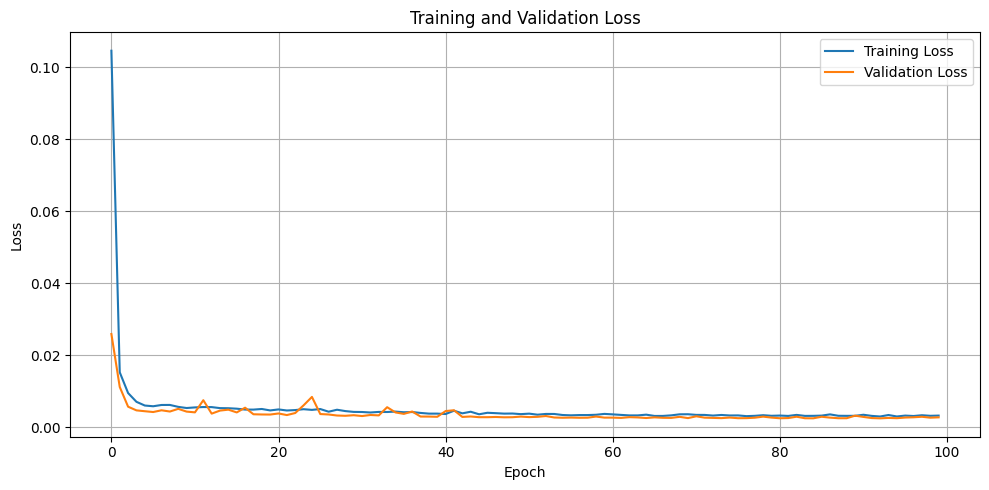

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../result/loss_plot_add_hidden_size and num_layers.png")
plt.show()

### original structure test ###

Test MSE: 3.3970
Test RMSE: 1.8431
Test MAE: 1.4876
Test R²: 0.9109


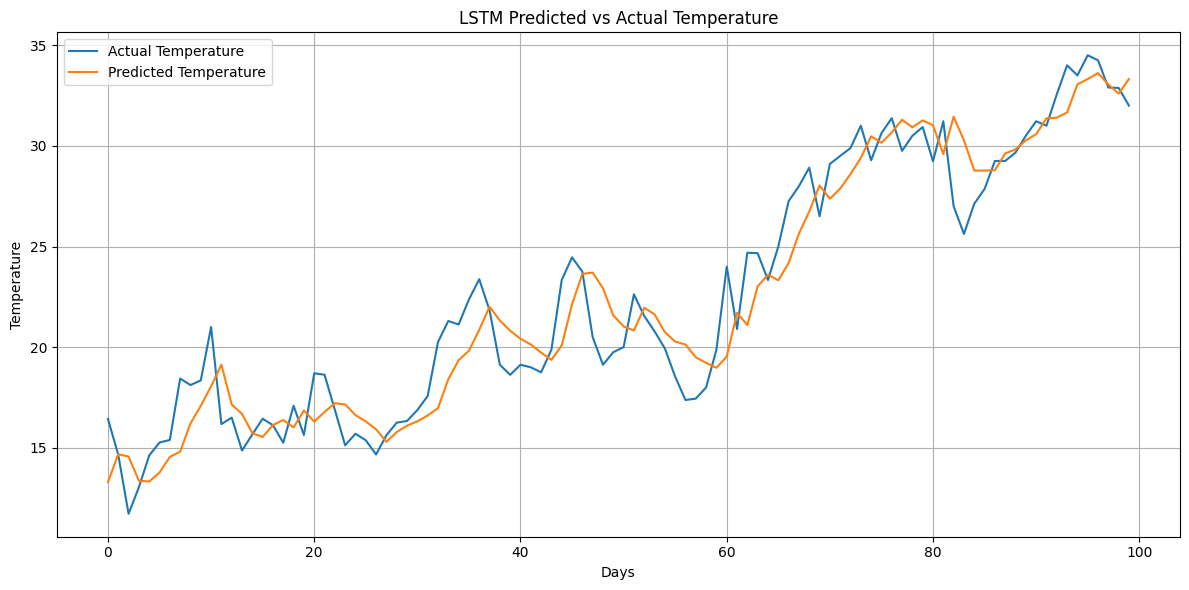

In [ ]:
# Predict on test data
model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        predictions.append(pred.item())

# Inverse transform to original scale
y_pred_inv = scaler.inverse_transform(np.hstack((np.array(predictions).reshape(-1, 1), np.zeros((len(predictions), 3)))))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 3)))))[:, 0]

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")
# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("LSTM Predicted vs Actual Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../result/test_plot.png")
plt.show()

### add increased hidden_size and num_layers structure test ###

Test MSE: 3.0835
Test RMSE: 1.7560
Test MAE: 1.4483
Test R²: 0.9191


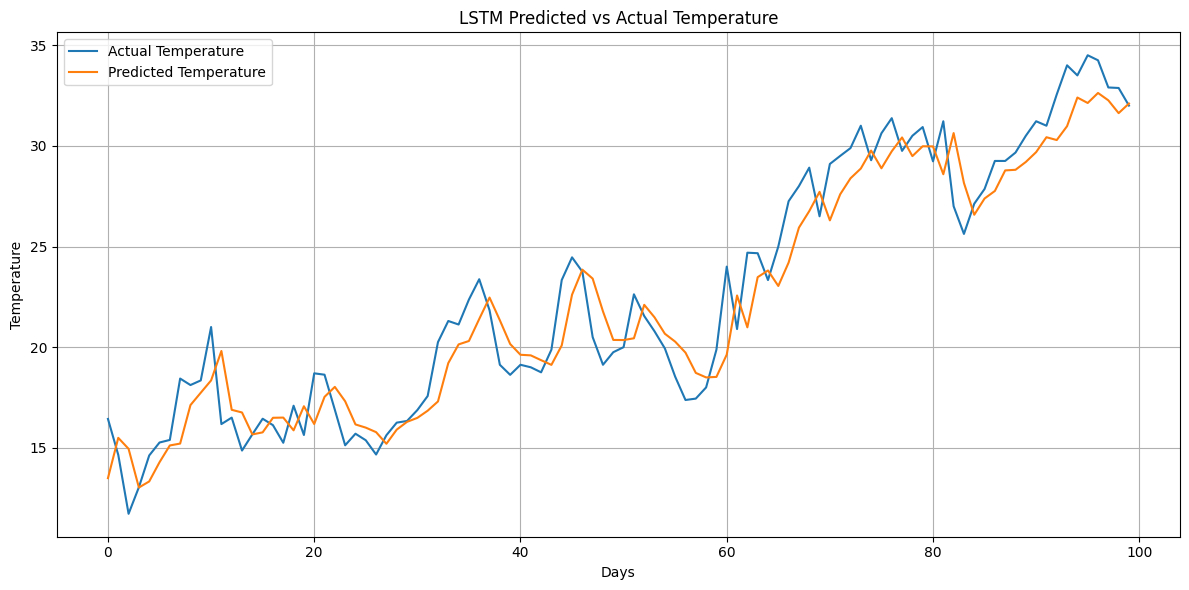

In [10]:
# Predict on test data
model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        predictions.append(pred.item())

# Inverse transform to original scale
y_pred_inv = scaler.inverse_transform(np.hstack((np.array(predictions).reshape(-1, 1), np.zeros((len(predictions), 3)))))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 3)))))[:, 0]

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")
# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Temperature')
plt.plot(y_pred_inv, label='Predicted Temperature')
plt.xlabel("Days")
plt.ylabel("Temperature")
plt.title("LSTM Predicted vs Actual Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../result/test_plot__add_hidden_size and num_layers.png")
plt.show()

In [11]:
torch.save(model.state_dict(), "../result/lstm_weather_model.pth")

In [11]:
# # filepath: d:\Dropbox\Fraunhofer\MA_copy\climate\code\climate_train_new.ipynb
# model.load_state_dict(torch.load("lstm_weather_model.pth"))
# model.eval()